## **Implementation on Bipartite Graph**

> To address the limitation of the knowledge graph on clustering each document based on their meaning, we will follow these steps:  

1. **Document/Entity Graph:**
   - **Entity Extraction:** extract keywords from each document
   - **Node Representation:** create bipartitte graph where one set of node consist of document representation and another set of node represent all keyword  


2. **Entity-Entity Graph:**
   - **Multiple Relationships:** then we start to project bipartite graph onto a set of keyword node to understand their relationship within keyword.  

3. **Filtering the Graph (Be aware of Dimension):**
   - due to many node and edges, we will need to filter for better analysis.  

4. **Analyzing the Graph:**
   - After we filter the graph relationship, then we are better able to visualize the relationship within the entity.

5. **Document-Document Graph:**
   - then we will repeat the step on analysis on entity-entity relationship in other to analyse on document document relationship


### **1. Bipartite Document-Entity Graph**  
> The term `"relevant entity"` is somewhat define a relevant entity as either a named entity (like an organization, person, or location recognized by the **NER engine**) or a keyword. Essentially, it's a **word or combination of words that identifies and generally describes the document and its content.**  
  
> Various algorithms can be employed to extract keywords from a document. One such method is `TF-IDF` (Term Frequency-Inverse Document Frequency) score. TF-IDF assigns a score to each word based on how often it appears in a specific document and how unique it is across the entire set of documents and `IDF` (the Inverse Document Frequency) considers the inverse frequency of a word across the entire corpus :

$$
\frac {C_{ij}}{\sum_{C_{ij}}}  * \log{N \over (1 + D_i)}
$$  
- $C_{ij}$ represents the count of the word i in document j.  
- $N$ is the total number of documents in the corpus.  
- $D_i$ is the document where the word i appears.  
  
> The `TF-IDF` score is designed to highlight words that are frequently repeated within a document while downplaying common words that might not be very distinctive.

> Another method that is more better than TF-IDF is `TextRank`. **But how does TextRank Operate?**  
  
- TextRank operates by **creating a network representation of a document based on a graph**. In this graph, individual words (tokens) serve as nodes, and edges are formed between them if the words are found within a specific window of each other.  

- Once this network is established, TextRank applies the `PageRank algorithm` to calculate the **centrality of each token**. Centrality is a measure of importance within the document, and PageRank assigns a score to each token, allowing for ranking based on this centrality score. The tokens with the highest centrality, typically within a certain percentage range (commonly between 5% and 20% of the document size), are recognized as candidate keywords.  
  
- When candidate keywords are in close proximity to each other, TextRank combines them into composite keywords, consisting of multiple tokens.  
  
- Implementations of TextRank are available in many NLP packages. One such package is `gensim`

In [41]:
from nltk.corpus import reuters
import pandas as pd
from langdetect import detect
import numpy as np
import spacy
import re

corpus = pd.DataFrame([
    {"id": _id,
     "text": reuters.raw(_id).replace("\n", ""), 
     "label": reuters.categories(_id)}
    for _id in reuters.fileids()
 ])

# Clean the Text
# def clean_text(text):
#     # Remove escape characters
#     text = text.replace("\n", "")
#     # Convert to lowercase
#     text = text.lower()
#     # Remove quotes around company names
#     text = re.sub(r'<(.*?)>', r'\1', text)
#     return text
# corpus['clean_text']=corpus["text"].apply(clean_text)
corpus["clean_text"] = corpus["text"].apply(
    lambda x: x.replace("\n", "")
 )

#Detect Language within Each Article of dataset
def getLanguage(text: str):
    try:
        return detect(text)
    except:
        return np.nan
corpus["language"] = corpus["text"].apply(detect)

# load the model NLP and apply to the clean text
nlp = spacy.load('en_core_web_md')
corpus["parsed"] = corpus["clean_text"]\
.apply(nlp)


In [42]:
from gensim.summarization import keywords

text = corpus["clean_text"][0]
extracted_keywords = keywords(text, words=10, split=True, scores=True,
                               pos_filter=('NN', 'JJ'), lemmatize=True)

extracted_keywords


[('trading', 0.4615130639538534),
 ('said', 0.31598556934945154),
 ('export', 0.26915538249580734),
 ('import', 0.17462010006456757),
 ('japanese electronics', 0.13609326263790325),
 ('industry', 0.1286043740379782),
 ('minister', 0.12229815662000455),
 ('japan', 0.11434500812642391),
 ('year', 0.10483992409352486)]

> The purpose of this line of code is to extract the top 10 keywords from the input text (text) while considering their scores, part-of-speech, and applying lemmatization. The result (extracted_keywords) is a list of tuples, where each tuple contains a keyword and its associated score.  
- `pos_filter`=('NN', 'JJ'): This parameter filters the extracted keywords based on their part-of-speech (POS). Here, it includes nouns (NN) and adjectives (JJ).  
- `scores`=True: This parameter, when set to True, causes the keywords function to return a list of tuples where each tuple contains a keyword and its score.  
> Here, the score represents the `centrality,` **which represents the importance of a given token**. As you can see, some composite tokens may also occur, such as japanese
electronics. Keyword extraction can be implemented to compute the keywords for
the entire corpus, thus storing the information in our corpus DataFrame:

In [43]:
##include keywords by taking only top 10 within or less 
# keywordsCorpus=[]
# for text in corpus["clean_text"]:
#     try:
#         extracted_keywords = keywords(text, words=10, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)
#         keywordsCorpus.append(extracted_keywords)
#     except Exception as e:
#         extracted_keywords = keywords(text, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True)
#         keywordsCorpus.append(extracted_keywords)



#corpus['keywords']=keywordsCorpus


In [44]:
corpus['keywords'] = corpus["clean_text"].apply(lambda text: keywords(text, split=True, scores=True, pos_filter=('NN', 'JJ'), lemmatize=True))
corpus.head()


,id,text,label,clean_text,language,parsed,keywords
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,en,"(ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA...","[(trading, 0.4615130639538521), (said, 0.31598..."
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,en,"(CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC...","[(vermin, 0.3120614380287164), (daily, 0.26110..."
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,en,"(JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM...","[(energy, 0.3857636092660117), (demand, 0.3479..."
3,test/14832,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,en,"(THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR...","[(pct, 0.5457455609144318), (export, 0.2656069..."
4,test/14833,INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,en,"(INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,...","[(indonesia, 0.2410428235502936), (harahap, 0...."


In [45]:
def extractEntities(ents, minValue=1, typeFilters=["GPE", "ORG", "PERSON"]):
    entities = pd.DataFrame([
        {
            "lemma": e.lemma_,
            "lower": e.lemma_.lower(),
            "type": e.label_
        } for e in ents if hasattr(e, "label_")
    ])
    if len(entities) == 0:
        return pd.DataFrame()
    g = entities.groupby(["type", "lower"])
    summary = pd.concat({
        "alias": g.apply(lambda x: x["lemma"].unique()),
        "count": g["lower"].count()
    }, axis=1)
    
    # Use boolean indexing to filter rows based on typeFilters
    filtered_summary = summary[summary["count"] > minValue]
    filtered_summary = filtered_summary[filtered_summary.index.get_level_values('type').isin(typeFilters)]
    
    return filtered_summary

def getOrEmpty(parsed, _type):
    try:
        return list(parsed.loc[_type]["count"]\
            .sort_values(ascending=False).to_dict().items())
    except:
        return []

def toField(ents):
    typeFilters = ["GPE", "ORG", "PERSON"]
    parsed = extractEntities(ents, 1, typeFilters)
    return pd.Series({_type: getOrEmpty(parsed, _type)
                      for _type in typeFilters})

> Besides the keywords, to build the bipartite graph, we also need **to parse the named entities that were extracted by the NER engine**, and then encode the information in a similar data format as the one that was used for the keywords.  
  
> These function just take each parsed from each text and find out the type of entities within each text where we filer for only type **Location, Organiation and Person**

In [46]:
entities = corpus["parsed"].apply(lambda x: toField(x.ents))

In [47]:
entities

,GPE,ORG,PERSON
0,"[(u.s., 14), (japan, 12), (taiwan, 3), (austra...",[],[]
1,"[(china, 2)]",[],[]
2,"[(japan, 2)]","[(miti, 4)]",[]
3,"[(thailand, 2)]",[],[]
4,"[(indonesia, 4), (malaysia, 2)]","[(cpo, 3)]","[(harahap, 2)]"
...,...,...,...
10783,[],[],[]
10784,[],[],[]
10785,[],[],[]
10786,[],[],[]


In [48]:
merged = pd.concat([corpus, entities], axis=1)
merged

,id,text,label,clean_text,language,parsed,keywords,GPE,ORG,PERSON
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,en,"(ASIAN, EXPORTERS, FEAR, DAMAGE, FROM, U.S.-JA...","[(trading, 0.4615130639538521), (said, 0.31598...","[(u.s., 14), (japan, 12), (taiwan, 3), (austra...",[],[]
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,en,"(CHINA, DAILY, SAYS, VERMIN, EAT, 7, -, 12, PC...","[(vermin, 0.3120614380287164), (daily, 0.26110...","[(china, 2)]",[],[]
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,en,"(JAPAN, TO, REVISE, LONG, -, TERM, ENERGY, DEM...","[(energy, 0.3857636092660117), (demand, 0.3479...","[(japan, 2)]","[(miti, 4)]",[]
3,test/14832,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,"[corn, grain, rice, rubber, sugar, tin, trade]",THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Th...,en,"(THAI, TRADE, DEFICIT, WIDENS, IN, FIRST, QUAR...","[(pct, 0.5457455609144318), (export, 0.2656069...","[(thailand, 2)]",[],[]
4,test/14833,INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,"[palm-oil, veg-oil]",INDONESIA SEES CPO PRICE RISING SHARPLY Indon...,en,"(INDONESIA, SEES, CPO, PRICE, RISING, SHARPLY,...","[(indonesia, 0.2410428235502936), (harahap, 0....","[(indonesia, 4), (malaysia, 2)]","[(cpo, 3)]","[(harahap, 2)]"
...,...,...,...,...,...,...,...,...,...,...
10783,training/999,U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...,"[interest, money-fx]",U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...,en,"(U.K., MONEY, MARKET, SHORTAGE, FORECAST, REVI...","[(market, 0.3364640504513756), (forecast, 0.33...",[],[],[]
10784,training/9992,KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY Qtl...,[earn],KNIGHT-RIDDER INC &lt;KRN> SETS QUARTERLY Qtl...,en,"(KNIGHT, -, RIDDER, INC, &, lt;KRN, >, SETS, Q...","[(april, 0.33086349685229777), (sets, 0.330863...",[],[],[]
10785,training/9993,TECHNITROL INC &lt;TNL> SETS QUARTERLY Qtly d...,[earn],TECHNITROL INC &lt;TNL> SETS QUARTERLY Qtly d...,en,"(TECHNITROL, INC, &, lt;TNL, >, SETS, QUARTERL...","[(april, 0.4784248004558341), (sets, 0.3366439...",[],[],[]
10786,training/9994,NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...,[earn],NATIONWIDE CELLULAR SERVICE INC &lt;NCEL> 4TH ...,en,"(NATIONWIDE, CELLULAR, SERVICE, INC, &, lt;NCE...","[(shrs, 0.4829561830574105), (loss, 0.44374355...",[],[],[]


> Now for all the incredient we got, we can build the bipartite graph now.

In [49]:
edges = pd.DataFrame([
{"source": _id, "target": keyword, "weight": score, "type":
_type}
for _id, row in merged.iterrows()
for _type in ["keywords", "GPE", "ORG", "PERSON"]
for (keyword, score) in row[_type]
])

In [50]:
edges

,source,target,weight,type
0,0,trading,0.461513,keywords
1,0,said,0.315986,keywords
2,0,export,0.269155,keywords
3,0,import,0.174620,keywords
4,0,japanese electronics,0.136093,keywords
...,...,...,...,...
76326,10785,sets,0.336644,keywords
76327,10786,shrs,0.482956,keywords
76328,10786,loss,0.443744,keywords
76329,10787,net,0.354102,keywords


In [51]:
edges[edges['type']=='keywords']

,source,target,weight,type
0,0,trading,0.461513,keywords
1,0,said,0.315986,keywords
2,0,export,0.269155,keywords
3,0,import,0.174620,keywords
4,0,japanese electronics,0.136093,keywords
...,...,...,...,...
76326,10785,sets,0.336644,keywords
76327,10786,shrs,0.482956,keywords
76328,10786,loss,0.443744,keywords
76329,10787,net,0.354102,keywords


> **List Comprehension to Create Rows in edges DataFrame:**  
- For each combination of` _id, _type, and (keyword, score)` in the nested loops, a dictionary is created with keys **"source", "target", "weight", and "type"**.  
- The values for these keys are:  
    - _id (source node)  
    - keyword (target node)  
    - score (weight of the edge)  
    - _type (type of the edge)

In [52]:
import networkx as nx

# Assuming 'edges' is a DataFrame with columns 'source' and 'target'
G = nx.Graph()

# Add nodes with bipartite attribute
G.add_nodes_from(edges["source"].unique(), bipartite=0) #1st set -- Document
G.add_nodes_from(edges["target"].unique(), bipartite=1) #2nd set -- Keywords of Texts

# Add edges
G.add_edges_from([(row["source"], row["target"]) for _, row in edges.iterrows()])

# Overview of the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())



Number of nodes: 22665
Number of edges: 71707
Average degree: 6.327553496580631


In [ ]:
+-----------------------------+------------+
|     Document-Entity Graph   |   Values   |
+-----------------------------+------------+
| Number of nodes             |   22665    |
| Number of edges             |   71707    |
| Average degree              |   6.3275   |
+-----------------------------+------------+

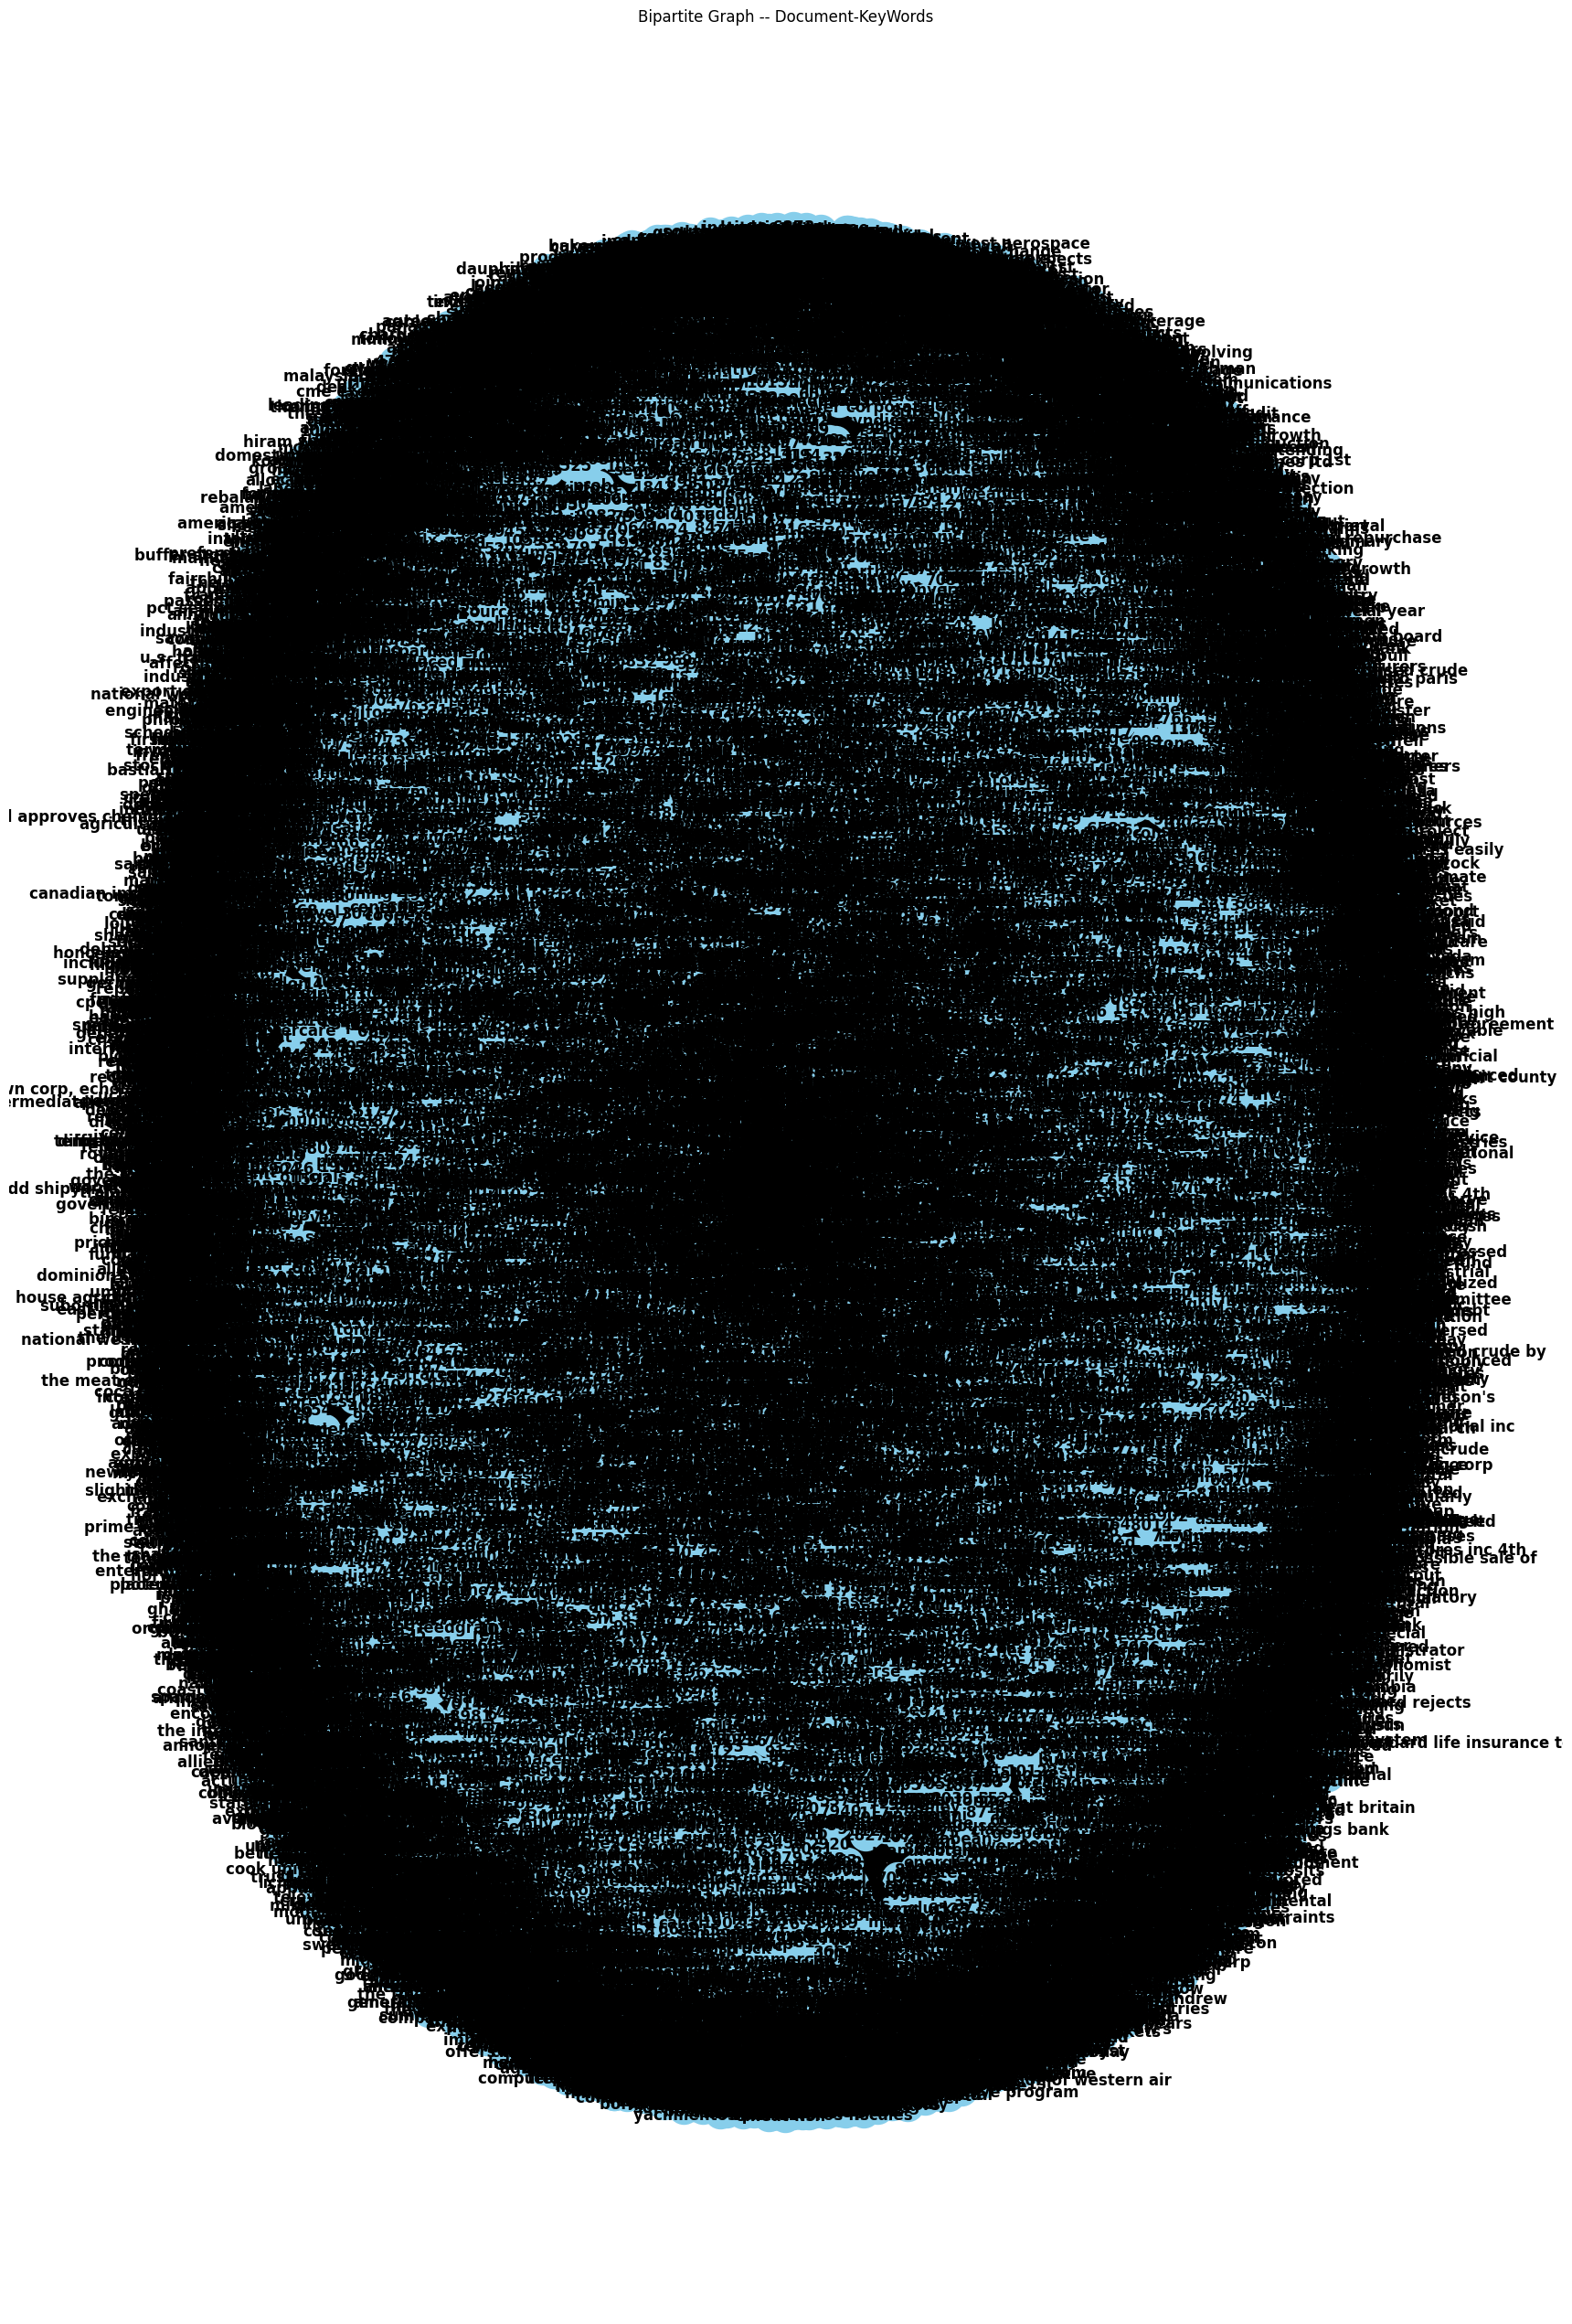

In [54]:
import matplotlib.pyplot as plt

# Assuming 'edges' is a DataFrame with columns 'source' and 'target'
G = nx.Graph()

# Add nodes with bipartite attribute
G.add_nodes_from(edges["source"].unique(), bipartite=0)  # 1st set -- Document
G.add_nodes_from(edges["target"].unique(), bipartite=1)  # 2nd set -- Keywords of Texts

# Add edges
G.add_edges_from([(row["source"], row["target"]) for _, row in edges.iterrows()])

# Create a layout for our nodes with increased separation
pos = {node: (0, i) for i, node in enumerate(edges["source"].unique())}
pos.update({node: (1, i) for i, node in enumerate(edges["target"].unique())})

# Draw the bipartite graph with a larger figure size
plt.figure(figsize=(17, 25))

# Use Fruchterman-Reingold layout for better node separation
pos = nx.spring_layout(G, seed=42, k=0.15)

nx.draw(G, pos, with_labels=True, font_weight="bold", node_color="skyblue", node_size=600)

# Add a title
plt.title("Bipartite Graph -- Document-KeyWords")

# Display the graph
plt.show()


> **Source** here represent the index of text so it represent an article or document.  
> **Target** hrer represent all of the Keywords within the text.  
> In the next part, We'll project bipartite graph that has two set of node and that where one is entities and another is the document. This will help us to understand between graph cluster both the terms (words or concepts) and document using unsupervised techniques. 


### **2.Entity-Entity Graph**  


> Before performing projection, we must extract the nodes relative to a **particular set (either documents or entities)** using the "bipartite" property we created when we generated the graph:

In [55]:
document_nodes = {n
        for n, d in G.nodes(data=True)
        if d["bipartite"] == 0}
entity_nodes = {n
        for n, d in G.nodes(data=True)
        if d["bipartite"] == 1}

In [56]:
projected_graph = nx.algorithms.bipartite.projection.projected_graph(G, entity_nodes)


In [57]:
weighted_entity_projection = nx.algorithms.bipartite.weighted_projected_graph(G, entity_nodes)


> We 2 set of node where one set is document represent and another is entities. 
> The code take the bipartite graph that being made above and seperate it into two set of nodees(documents and entities), then project the graph onto the set of entity nodes, creating new graph that show connection between entities based on their shared relationship within the document.

> Next We will use`overlap_weighted_projected_graph`, where the edge weight is computed using the `Jaccard similarity` based on common neighbors

### **Be aware of dimension - filering the graph**

In [ ]:
nodes_with_low_degree = {n 
 for n, d in nx.degree(G, nbunch=entity_nodes) if d<5}
subGraph = G.subgraph(set(G.nodes) - nodes_with_low_degree)

In [ ]:
entityGraph = nx.algorithms.bipartite.projection.overlap_weighted_projected_graph(
 subGraph,
 {n for n in subGraph.nodes() if n in entity_nodes}
)


In [ ]:
+-------------------+------------+
|     EntityGraph   |   Values   |
+-------------------+------------+
| Number of nodes   |   1993     |
| Number of edges   |  131448    |
| Average degree    | 131.9097   |
+-------------------+------------+

In [ ]:
# Overview of the graph
print("=====SubGraph=====")
print("Number of nodes:", subGraph.number_of_nodes())
print("Number of edges:", subGraph.number_of_edges())
print("Average degree:", sum(dict(subGraph.degree()).values()) / subGraph.number_of_nodes())
print("=====EntityGraph=====")
print("Number of nodes:", entityGraph.number_of_nodes())
print("Number of edges:", entityGraph.number_of_edges())
print("Average degree:", sum(dict(entityGraph.degree()).values()) / entityGraph.number_of_nodes())

=====SubGraph=====
Number of nodes: 12705
Number of edges: 56987
Average degree: 8.970798898071626
=====EntityGraph=====
Number of nodes: 1993
Number of edges: 131448
Average degree: 131.9096838936277


In [ ]:
filteredEntityGraph = entityGraph.edge_subgraph(
 [edge 
 for edge in entityGraph.edges
if entityGraph.edges[edge]["weight"]>0.05])

In [ ]:
print("=====FilteredEntityGraph=====")
print("Number of nodes:", filteredEntityGraph.number_of_nodes())
print("Number of edges:", filteredEntityGraph.number_of_edges())
print("Average degree:", sum(dict(filteredEntityGraph.degree()).values()) / filteredEntityGraph.number_of_nodes())

=====FilteredEntityGraph=====
Number of nodes: 1904
Number of edges: 10052
Average degree: 10.558823529411764


In [ ]:
# Step 1: Get the connected components
components = nx.connected_components(filteredEntityGraph)
pd.Series([len(c) for c in components])


0    1880
1       7
2       2
3       2
4       2
5       2
6       2
7       3
8       2
9       2
dtype: int64

In [ ]:
components = nx.connected_components(filteredEntityGraph)
first_component = next(components)  # Retrieve the first element from the generator

# Now, 'first_component' is a set containing the nodes of the first connected component
print(first_component)


{'silver', 'data', 'productivity', 'november', 'countries', 'piedmont', 'west germany', 'favorable', 'point', 'need', 'billion dlrs', 'federal', 'charge', 'started', 'regional', 'alan', 'war', 'tokyo', 'cooperation', 'auto', 'outlook', 'won', 'takeovers', 'inra', 'petrochemical', 'argentina', 'ibc', 'yen', 'authority', 'poultry', 'ill', 'cents', 'decision', 'seoul', 'debts', 'banks', 'communique', 'oils', 'pesos', 'single', 'additional', 'jones', 'chase', 'set', 'consumers', 'indonesian', 'heavy', 'petrol', 'dow', 'damage', 'session', 'finland', 'light', 'operators', 'media', 'reduce', 'virginia', 'commissioner', 'turkey', 'sheet', 'weight', 'corporation', 'negotiated', 'entertainment', 'crisis', 'nppc', 'grade', 'west', 'beet', 'coins', 'sharp', 'big', 'kuwait', 'small', 'caesars world', 'gelco', 'defence', 'general', 'earlier', 'canada', 'political', 'bhp', 'warner', 'aid', 'planning', 'bags', 'calif', 'canal', 'specialty', 'venezuela', 'analyst', 'buyers', 'output', 'newspaper', 'sp

In [ ]:
# Step 2: Extract the first connected component
first_component_nodes = next(components)
first_component = filteredEntityGraph.subgraph(first_component_nodes)

# Step 3: Calculate network metrics for the first connected component
shortest_path = nx.average_shortest_path_length(first_component)
clustering_coefficient = nx.average_clustering(first_component)
global_efficiency = nx.global_efficiency(first_component)

# Step 4: Create a Pandas Series for the metrics
component_metrics = pd.Series({
    "Shortest Path": shortest_path,
    "Clustering Coefficient": clustering_coefficient,
    "Global Efficiency": global_efficiency
})

# Display the calculated metrics
print("Network Metrics for the First Connected Component:")
print(component_metrics)

Network Metrics for the First Connected Component:
Shortest Path             2.380952
Clustering Coefficient    0.000000
Global Efficiency         0.553175
dtype: float64
